# Dimensional Analysis for Quality Control in Manufacturing using Blob Detection

## Import the Image and convert to Grayscale

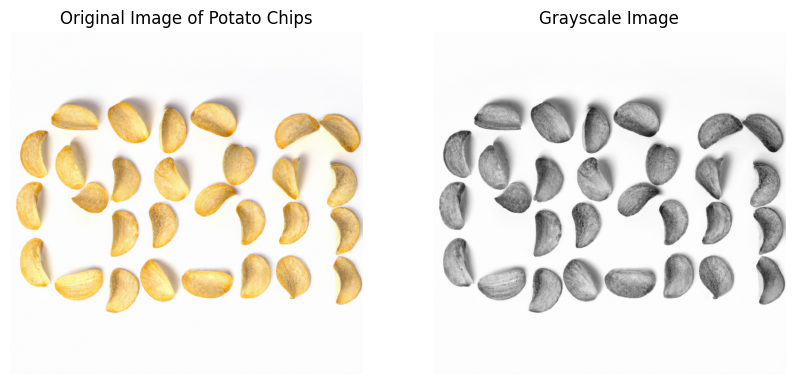

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set the Product Name
prod = "Potato Chips"

# Load the image
image = cv2.imread("chips1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display both Original and Grayscale images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Global Thresholding Result
axes[0].imshow(image)
axes[0].set_title("Original Image of "+prod)
axes[0].axis("off")

# Adaptive Thresholding Result
axes[1].imshow(gray, cmap="gray")
axes[1].set_title("Grayscale Image")
axes[1].axis("off")

plt.show()


## Pre-Processing

Applied Gaussian blur to the grayscale image using cv2.GaussianBlur() to reduce noise. You can adjust the kernel size (5, 5) based on the amount of noise in your image.

https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html

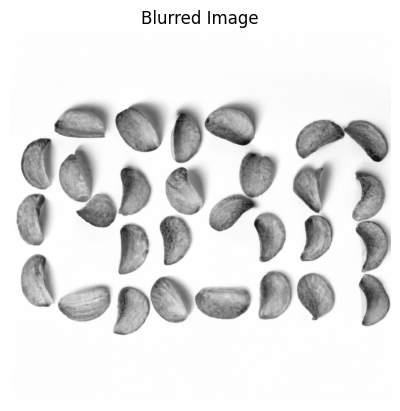

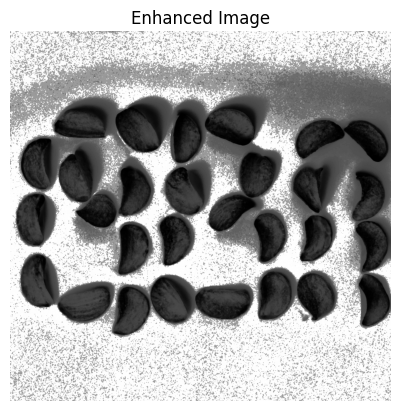

In [4]:
# Apply Gaussian blur to reduce noise
# blurred = cv2.GaussianBlur(gray, (11, 11), 0)

# Apply Median blur to reduce noise
blurred = cv2.medianBlur(gray, 3)

# Display the blurred image
plt.imshow(blurred, cmap="gray")
plt.title("Blurred Image")
plt.axis("off")
plt.show()


# Contrast Enhancement
enhanced_image = cv2.equalizeHist(blurred)  # Apply histogram equalization for contrast enhancement

# Display the Histogram Equalized image
plt.imshow(enhanced_image, cmap="gray")
plt.title("Enhanced Image")
plt.axis("off")
plt.show()

## Thresholding

Performed thresholding on the blurred image to create a binary image using cv2.threshold(). This step helps to segment the Chips from the background.

In [5]:
# Apply Global Thresholding
def binary_threshold(image, threshold_value):

    # Apply binary thresholding
    _, binary_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY_INV)

    return binary_image


In [6]:
# Apply Adaptive Thresholding
def adaptive_threshold(image, block_size, constant):

    # Apply adaptive thresholding
    binary_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY_INV, block_size, constant)

    return binary_image

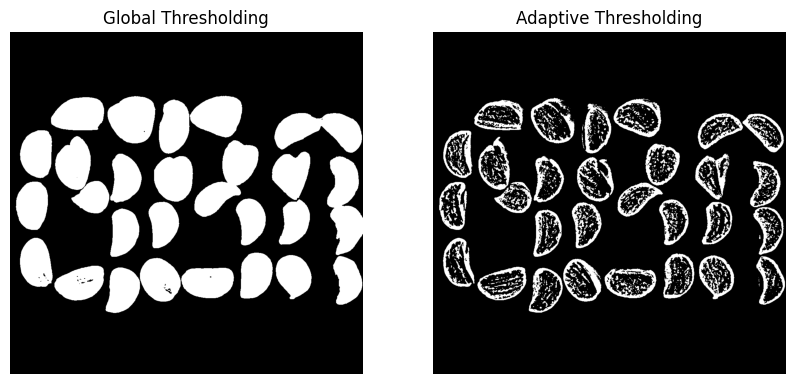

In [7]:
# Apply thresholding to segment the Chips

# Adjust the Global threshold_value
threshold_value = 230
thresh_global = binary_threshold(blurred, threshold_value)

# Adjust the block_size and constant
block_size = 35
constant = 5
thresh_adaptive = adaptive_threshold(blurred, block_size, constant)

# Assign the Best Thresholded Image as the Final Binay Image
thresh = thresh_global

# Display both binary images side by side using matplotlib
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Global Thresholding Result
axes[0].imshow(thresh_global, cmap="gray")
axes[0].set_title("Global Thresholding")
axes[0].axis("off")

# Adaptive Thresholding Result
axes[1].imshow(thresh_adaptive, cmap="gray")
axes[1].set_title("Adaptive Thresholding")
axes[1].axis("off")

plt.show()

## Morphological Processing

https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html

* Morphological Closing: Morphological closing is an operation that combines dilation followed by erosion. It is used to fill gaps in the detected blobs and smooth the blobs. In this code, a square-shaped kernel of size (5, 5) is used for the closing operation. The cv2.morphologyEx() function is applied with cv2.MORPH_CLOSE as the operation type.

* Morphological Erosion: Morphological erosion is an operation that reduces the size of bright regions (white areas in this case). It helps distinguish blobs that are close to each other. In this code, a smaller square-shaped kernel of size (3, 3) is used for the erosion operation. The cv2.erode() function is applied with iterations=1 to perform one iteration of erosion.

* Morphological Dilation: Morphological dilation is an operation that increases the size of bright regions. It is used here to fill small gaps inside each blobs, which might have occurred due to thresholding or erosion. In this code, a larger square-shaped kernel of size (7, 7) is used for the dilation operation. The cv2.dilate() function is applied with iterations=1 to perform one iteration of dilation.

By applying morphological closing, erosion, and dilation in this order, we improve the accuracy of blob detection and separation of adjacent blobs. Closing helps to fill small gaps and smooth the blobs, erosion helps distinguish closely connected blobs, and dilation fills small gaps inside each blueberry, leading to more accurate detection of individual blobs in the final output.

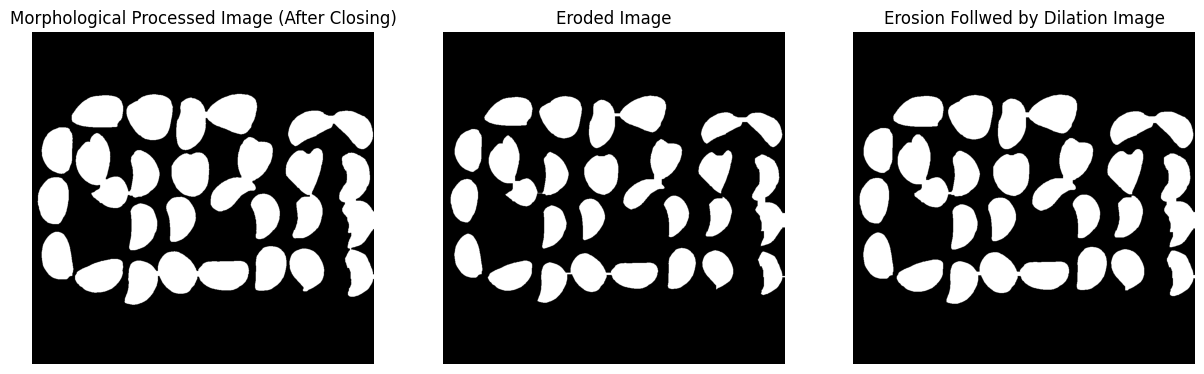

In [29]:
# Perform morphological closing to fill gaps and smooth the blobs
kernel = np.ones((5, 5), np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# Perform morphological erosion to distinguish blobs
kernel_erosion = np.ones((11, 11), np.uint8)
erosion = cv2.erode(closing, kernel_erosion, iterations=1)

# Perform morphological dilation to fill small gaps inside each blob
kernel_dilation = np.ones((7, 7), np.uint8)
dilation = cv2.dilate(erosion, kernel_dilation, iterations=1)

# Set the Processed Image for Connected Component Analysis
processed_img = erosion

# Display Closed, Eroded, Dilated images side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Morphological Processsing - Closing Result
axes[0].imshow(closing, cmap="gray")
axes[0].set_title("Morphological Processed Image (After Closing)")
axes[0].axis("off")

# Morphological Processsing - Erosion Result
axes[1].imshow(erosion, cmap="gray")
axes[1].set_title("Eroded Image")
axes[1].axis("off")

# Morphological Processsing - Erosion, Followed by Dilation Result
axes[2].imshow(dilation, cmap="gray")
axes[2].set_title("Erosion Follwed by Dilation Image")
axes[2].axis("off")

plt.show()

## Blob Detection and Measurement

added two conditions to the loop that iterates through the blobs. The if statement checks if the area of the blob falls within the specified range (min_area_threshold < area < max_area_threshold). If it does, the blob will be considered for further processing (drawing a bounding box and printing the area).

You can adjust the values of min_area_threshold and max_area_threshold to filter the blobs based on the desired size range. Blobs with an area less than min_area_threshold or greater than max_area_threshold will be excluded from further processing. By tuning these values, you can filter out noise or other unwanted detections in the image.

Total Blobs Count: 22
Chips 1: Area = 19404 pixels
Chips 2: Area = 11989 pixels
Chips 3: Area = 9629 pixels
Chips 4: Area = 13436 pixels
Chips 5: Area = 8131 pixels
Chips 6: Area = 21619 pixels
Chips 7: Area = 14281 pixels
Chips 8: Area = 8198 pixels
Chips 9: Area = 9654 pixels
Chips 10: Area = 14742 pixels
Chips 11: Area = 8114 pixels
Chips 12: Area = 6197 pixels
Chips 13: Area = 6149 pixels
Chips 14: Area = 6674 pixels
Chips 15: Area = 6745 pixels
Chips 16: Area = 8210 pixels
Chips 17: Area = 7925 pixels
Chips 18: Area = 7288 pixels
Chips 19: Area = 6025 pixels
Chips 20: Area = 25323 pixels
Chips 21: Area = 8257 pixels


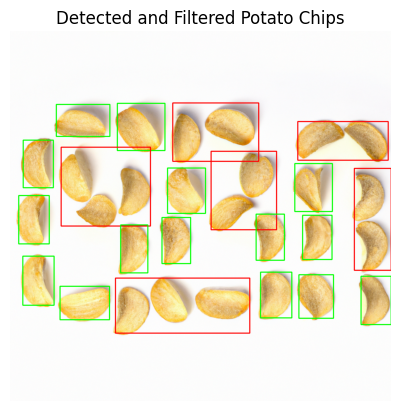

In [36]:
# Perform connected component analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(processed_img, connectivity=8)

# Print Total Number of Blobs Detected
print(f"Total Blobs Count: {num_labels}")

# Define the minimum and maximum area thresholds to filter the blobs (adjust these values as needed)
min_area_threshold = 500

# Define the Filtering Blob Size above which is Connected Chips
max_area_threshold = 12000

# Loop through each detected blob
for label in range(1, num_labels):  # Start from 1 to exclude the background label 0
    area = stats[label, cv2.CC_STAT_AREA]

    # Check if the area is within the specified range
    if min_area_threshold < area:

        # Get the bounding box coordinates for the blob
        x, y, w, h = stats[label, cv2.CC_STAT_LEFT], stats[label, cv2.CC_STAT_TOP], \
                     stats[label, cv2.CC_STAT_WIDTH], stats[label, cv2.CC_STAT_HEIGHT]

        # Draw a bounding box around the blob
        # if the Area is more than Max allowed Add RED box, Else Green
        if  area < max_area_threshold:
          cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        else:
          cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Print the area of the blob
        print(f"Chips {label}: Area = {area} pixels")

# Display the final output with detected and Filtered Blobs
plt.imshow(image)
plt.title("Detected and Filtered "+prod)
plt.axis("off")
plt.show()